# 性早熟预测模型（精简特征版）

**使用精简特征集（9个特征）进行模型训练**

精简特征基于医生临床经验筛选：
- LH/FSH 相关：基础LH、基础FSH、LH/FSH比值
- 骨龄相关：骨龄、骨龄与实际年龄比值
- 子宫卵巢径线/体积：子宫长宽厚体积、左右卵巢长宽厚体积

## 1. 导入必要的库

In [2]:
import os

os.environ["SCIPY_ARRAY_API"] = "1"

import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    f1_score,
)
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve
import xgboost as xgb
from tabpfn import TabPFNClassifier
import tabm
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import graphviz


plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

import re
import joblib


def create_missforest_imputer(random_state=825):
    """创建MissForest插补器（IterativeImputer + RandomForest）"""
    return IterativeImputer(
        estimator=RandomForestRegressor(
            n_estimators=10,
            max_depth=10,
            n_jobs=-1,
            random_state=random_state,
        ),
        max_iter=10,
        random_state=random_state,
        verbose=0,
    )


if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"显存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

GPU: NVIDIA GeForce RTX 3080 Laptop GPU
显存: 16.0 GB


## 2. 设置路径和参数

In [3]:
os.makedirs("./output", exist_ok=True)
os.makedirs("./output/ml_simplified", exist_ok=True)
os.makedirs("./output/ml_simplified/models", exist_ok=True)

RANDOM_SEED = 825
np.random.seed(RANDOM_SEED)
N_JOBS = -1

print(f"随机种子: {RANDOM_SEED}")
print(f"输出目录: ./output/ml_simplified/")

随机种子: 825
输出目录: ./output/ml_simplified/


## 3. 读取精简特征数据

In [4]:
normal_data = pd.read_csv("./input/性早熟数据激发试验正常组_simplified.csv")
disease_data = pd.read_csv("./input/激发试验确诊性早熟组数据_simplified.csv")

normal_data["group"] = "N"
disease_data["group"] = "Y"

print(f"正常组: {normal_data.shape[0]} 行, {normal_data.shape[1]} 列")
print(f"早熟组: {disease_data.shape[0]} 行, {disease_data.shape[1]} 列")
print(f"\n精简特征列表:")
for col in normal_data.columns:
    if col not in ["group", "患者编号"]:
        print(f"  - {col}")

正常组: 4009 行, 11 列
早熟组: 5877 行, 11 列

精简特征列表:
  - 基础血清促黄体生成激素（LH）
  - 基础血清卵泡刺激素（FSH）
  - 骨龄(岁)
  - 骨龄与实际年龄比值
  - 子宫长（cm）
  - 子宫厚（cm）
  - 左卵巢体积（长X宽X厚X0.5233）
  - 右卵巢体积（长X宽X厚X0.5233）
  - LH/FSH比值


## 4. 数据类型处理和合并

In [5]:
data = pd.concat([normal_data, disease_data], axis=0, ignore_index=True)
data["group"] = data["group"].astype("category")
print(f"合并后数据: {data.shape[0]} 行 x {data.shape[1]} 列")

合并后数据: 9886 行 x 11 列


## 5. 查看数据基本信息

In [6]:
print("数据基本信息:")
print(f"数据维度: {data.shape}")
print(f"分组统计:")
print(data["group"].value_counts())
print(f"数据类型:")
print(data.dtypes.value_counts())
print(f"缺失值统计:")
missing_count = data.isnull().sum().sum()
print(f"总缺失值数量: {missing_count}")
if missing_count > 0:
    missing_by_col = data.isnull().sum()
    missing_by_col = missing_by_col[missing_by_col > 0].sort_values(ascending=False)
    print("各列缺失值:")
    print(missing_by_col.head(10))

数据基本信息:
数据维度: (9886, 11)
分组统计:
group
Y    5877
N    4009
Name: count, dtype: int64
数据类型:
float64     10
category     1
Name: count, dtype: int64
缺失值统计:
总缺失值数量: 5219
各列缺失值:
骨龄与实际年龄比值              1401
骨龄(岁)                  1399
子宫厚（cm）                 945
子宫长（cm）                 936
左卵巢体积（长X宽X厚X0.5233）     325
右卵巢体积（长X宽X厚X0.5233）     209
LH/FSH比值                  3
基础血清促黄体生成激素（LH）           1
dtype: int64


## 6. 划分训练集和验证集

In [7]:
train_data, validation_data = train_test_split(
    data, test_size=0.3, stratify=data["group"], random_state=RANDOM_SEED
)

print(f"训练集: {train_data.shape[0]} 行, 验证集: {validation_data.shape[0]} 行")

训练集: 6920 行, 验证集: 2966 行


## 7. 特征工程

In [8]:
exclude_cols = ["group", "患者编号", "Unnamed: 0"]
feature_cols = [col for col in train_data.columns if col not in exclude_cols]

X_train = train_data[feature_cols].copy()
y_train = train_data["group"].copy()
X_validation = validation_data[feature_cols].copy()
y_validation = validation_data["group"].copy()

y_train_binary = (y_train == "Y").astype(int)
y_validation_binary = (y_validation == "Y").astype(int)

print(f"使用 {len(feature_cols)} 个精简特征")
print(f"训练集正负样本: {y_train_binary.value_counts().to_dict()}")
print(f"验证集正负样本: {y_validation_binary.value_counts().to_dict()}")

使用 9 个精简特征
训练集正负样本: {1: 4114, 0: 2806}
验证集正负样本: {1: 1763, 0: 1203}


## 8. 特征概览和缺失值填补（MissForest方法）

In [9]:
print(f"特征列表 ({len(feature_cols)}个特征):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

print(f"\n训练集: {X_train.shape[0]}样本, 验证集: {X_validation.shape[0]}样本")
print(f"训练集正负样本: {y_train_binary.value_counts().to_dict()}")
print(f"验证集正负样本: {y_validation_binary.value_counts().to_dict()}")

# 缺失值分析
missing_train = X_train.isnull().sum()
missing_pct = (missing_train / len(X_train) * 100).round(2)
missing_info = (
    pd.DataFrame({"缺失数量": missing_train, "缺失率(%)": missing_pct})
    .query("缺失数量 > 0")
    .sort_values("缺失率(%)", ascending=False)
)

if not missing_info.empty:
    print(f"\n缺失值分析:")
    print(missing_info.to_string())

# 使用MissForest方法填补所有特征
print("\n" + "=" * 60)
print("缺失值填补（MissForest方法）")
print("=" * 60)

imputer = create_missforest_imputer(RANDOM_SEED)
print("使用MissForest方法填补缺失值...")

X_train_arr = imputer.fit_transform(X_train)
X_validation_arr = imputer.transform(X_validation)

# 转换为DataFrame保持列名
X_train_imputed = pd.DataFrame(X_train_arr, columns=feature_cols, index=X_train.index)
X_validation_imputed = pd.DataFrame(
    X_validation_arr, columns=feature_cols, index=X_validation.index
)

# 标准化（用于KNN/SVM/NNET等模型）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_validation_scaled = scaler.transform(X_validation_imputed)

print(f"\n填补完成！")
print(f"  处理后特征数: {X_train_imputed.shape[1]}")
print(f"  缺失值检查: {X_train_imputed.isnull().sum().sum()} (应为0)")

特征列表 (9个特征):
   1. 基础血清促黄体生成激素（LH）
   2. 基础血清卵泡刺激素（FSH）
   3. 骨龄(岁)
   4. 骨龄与实际年龄比值
   5. 子宫长（cm）
   6. 子宫厚（cm）
   7. 左卵巢体积（长X宽X厚X0.5233）
   8. 右卵巢体积（长X宽X厚X0.5233）
   9. LH/FSH比值

训练集: 6920样本, 验证集: 2966样本
训练集正负样本: {1: 4114, 0: 2806}
验证集正负样本: {1: 1763, 0: 1203}

缺失值分析:
                     缺失数量  缺失率(%)
骨龄与实际年龄比值             983   14.21
骨龄(岁)                 982   14.19
子宫厚（cm）               673    9.73
子宫长（cm）               665    9.61
左卵巢体积（长X宽X厚X0.5233）   224    3.24
右卵巢体积（长X宽X厚X0.5233）   134    1.94
LH/FSH比值                3    0.04
基础血清促黄体生成激素（LH）         1    0.01

缺失值填补（MissForest方法）
使用MissForest方法填补缺失值...

填补完成！
  处理后特征数: 9
  缺失值检查: 0 (应为0)


---
# 模型训练

## 10. 设置交叉验证策略

In [10]:
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_SEED)

print(f"验证策略: 5折交叉验证 x 3次重复 = {cv_strategy.get_n_splits()}轮")
print(f"训练集: {len(X_train)}样本, 正负比={y_train_binary.value_counts().to_dict()}")
print(
    f"验证集: {len(X_validation)}样本, 正负比={y_validation_binary.value_counts().to_dict()}"
)

验证策略: 5折交叉验证 x 3次重复 = 15轮
训练集: 6920样本, 正负比={1: 4114, 0: 2806}
验证集: 2966样本, 正负比={1: 1763, 0: 1203}


## 11. 训练模型1: GBM (梯度提升机)

In [11]:
gbm_model = HistGradientBoostingClassifier(
    max_iter=100,
    max_depth=3,
    learning_rate=0.01,
    l2_regularization=0.1,
    min_samples_leaf=10,
    random_state=RANDOM_SEED,
)
gbm_model.fit(X_train_imputed, y_train_binary)

y_pred_gbm = gbm_model.predict(X_validation_imputed)
y_pred_proba_gbm = gbm_model.predict_proba(X_validation_imputed)[:, 1]
auc_gbm = roc_auc_score(y_validation_binary, y_pred_proba_gbm)
f1_gbm = f1_score(y_validation_binary, y_pred_gbm)

joblib.dump(gbm_model, "./output/ml_simplified/models/gbm_model.pkl")
print(f"GBM AUC: {auc_gbm:.4f}, F1: {f1_gbm:.4f}")

GBM AUC: 0.7936, F1: 0.8027


## 12. 训练模型2: KNN (K近邻)

In [12]:
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=N_JOBS)
knn_model.fit(X_train_scaled, y_train_binary)

y_pred_knn = knn_model.predict(X_validation_scaled)
y_pred_proba_knn = knn_model.predict_proba(X_validation_scaled)[:, 1]
auc_knn = roc_auc_score(y_validation_binary, y_pred_proba_knn)
f1_knn = f1_score(y_validation_binary, y_pred_knn)

joblib.dump(
    {"model": knn_model, "imputer": imputer, "scaler": scaler},
    "./output/ml_simplified/models/knn_model.pkl",
)
print(f"KNN AUC: {auc_knn:.4f}, F1: {f1_knn:.4f}")

KNN AUC: 0.7261, F1: 0.7597


## 13. 训练模型3: Naive Bayes (朴素贝叶斯)

In [13]:
nb_model = GaussianNB()
nb_model.fit(X_train_imputed, y_train_binary)

y_pred_nb = nb_model.predict(X_validation_imputed)
y_pred_proba_nb = nb_model.predict_proba(X_validation_imputed)[:, 1]
auc_nb = roc_auc_score(y_validation_binary, y_pred_proba_nb)
f1_nb = f1_score(y_validation_binary, y_pred_nb)

joblib.dump(
    {"model": nb_model, "imputer": imputer},
    "./output/ml_simplified/models/nb_model.pkl",
)
print(f"NB AUC: {auc_nb:.4f}, F1: {f1_nb:.4f}")

NB AUC: 0.6859, F1: 0.4379


## 14. 训练模型4: XGBoost (极限梯度提升)

In [14]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.013,
    random_state=RANDOM_SEED,
    tree_method="hist",
    n_jobs=N_JOBS,
)
xgb_model.fit(X_train_imputed, y_train_binary)

y_pred_xgb = xgb_model.predict(X_validation_imputed)
y_pred_proba_xgb = xgb_model.predict_proba(X_validation_imputed)[:, 1]
auc_xgb = roc_auc_score(y_validation_binary, y_pred_proba_xgb)
f1_xgb = f1_score(y_validation_binary, y_pred_xgb)

joblib.dump(xgb_model, "./output/ml_simplified/models/xgb_model.pkl")
print(f"XGB AUC: {auc_xgb:.4f}, F1: {f1_xgb:.4f}")

XGB AUC: 0.8190, F1: 0.8218


## 15. 训练模型5: Random Forest (随机森林)

In [15]:
rf_model = RandomForestClassifier(
    n_estimators=500, random_state=RANDOM_SEED, n_jobs=N_JOBS
)
rf_model.fit(X_train_imputed, y_train_binary)

y_pred_rf = rf_model.predict(X_validation_imputed)
y_pred_proba_rf = rf_model.predict_proba(X_validation_imputed)[:, 1]
auc_rf = roc_auc_score(y_validation_binary, y_pred_proba_rf)
f1_rf = f1_score(y_validation_binary, y_pred_rf)

joblib.dump(rf_model, "./output/ml_simplified/models/rf_model.pkl")
print(f"RF AUC: {auc_rf:.4f}, F1: {f1_rf:.4f}")

RF AUC: 0.7687, F1: 0.7844


## 16. 训练模型6: RPART (决策树)

In [16]:
rpart_model = DecisionTreeClassifier(
    max_depth=5, min_samples_split=50, min_samples_leaf=20, random_state=RANDOM_SEED
)
rpart_model.fit(X_train_imputed, y_train_binary)

y_pred_rpart = rpart_model.predict(X_validation_imputed)
y_pred_proba_rpart = rpart_model.predict_proba(X_validation_imputed)[:, 1]
auc_rpart = roc_auc_score(y_validation_binary, y_pred_proba_rpart)
f1_rpart = f1_score(y_validation_binary, y_pred_rpart)

joblib.dump(
    {"model": rpart_model, "imputer": imputer},
    "./output/ml_simplified/models/rpart_model.pkl",
)
print(f"RPART AUC: {auc_rpart:.4f}, F1: {f1_rpart:.4f}")

RPART AUC: 0.7812, F1: 0.7882


## 17. 训练模型7: GLM (逻辑回归)

In [17]:
glm_model = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED, n_jobs=N_JOBS)
glm_model.fit(X_train_imputed, y_train_binary)

y_pred_glm = glm_model.predict(X_validation_imputed)
y_pred_proba_glm = glm_model.predict_proba(X_validation_imputed)[:, 1]
auc_glm = roc_auc_score(y_validation_binary, y_pred_proba_glm)
f1_glm = f1_score(y_validation_binary, y_pred_glm)

joblib.dump(
    {"model": glm_model, "imputer": imputer},
    "./output/ml_simplified/models/glm_model.pkl",
)
print(f"GLM AUC: {auc_glm:.4f}, F1: {f1_glm:.4f}")

GLM AUC: 0.7097, F1: 0.7332


## 18. 训练模型8: SVM (支持向量机)

In [18]:
svm_model = SVC(kernel="rbf", probability=True, random_state=RANDOM_SEED)
svm_model.fit(X_train_scaled, y_train_binary)

y_pred_svm = svm_model.predict(X_validation_scaled)
y_pred_proba_svm = svm_model.predict_proba(X_validation_scaled)[:, 1]
auc_svm = roc_auc_score(y_validation_binary, y_pred_proba_svm)
f1_svm = f1_score(y_validation_binary, y_pred_svm)

joblib.dump(
    {"model": svm_model, "imputer": imputer, "scaler": scaler},
    "./output/ml_simplified/models/svm_model.pkl",
)
print(f"SVM AUC: {auc_svm:.4f}, F1: {f1_svm:.4f}")

SVM AUC: 0.7743, F1: 0.8026


## 19. 训练模型9: NNET (神经网络)

In [19]:
nnet_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    max_iter=500,
    random_state=RANDOM_SEED,
    early_stopping=True,
)
nnet_model.fit(X_train_scaled, y_train_binary)

y_pred_nnet = nnet_model.predict(X_validation_scaled)
y_pred_proba_nnet = nnet_model.predict_proba(X_validation_scaled)[:, 1]
auc_nnet = roc_auc_score(y_validation_binary, y_pred_proba_nnet)
f1_nnet = f1_score(y_validation_binary, y_pred_nnet)

joblib.dump(
    {"model": nnet_model, "imputer": imputer, "scaler": scaler},
    "./output/ml_simplified/models/nnet_model.pkl",
)
print(f"NNET AUC: {auc_nnet:.4f}, F1: {f1_nnet:.4f}")

NNET AUC: 0.7831, F1: 0.7905


## 20. 导入模型10: TabM

In [ ]:
print("=" * 70)
print("导入TabM模型（HPO优化版）")
print("=" * 70)

import rtdl_num_embeddings

# 加载HPO配置和模型
tabm_hpo_config_path = "./output/tabm_simplified/models/tabm_hpo_config.pkl"
tabm_model_path = "./output/tabm_simplified/models/tabm_hpo.pt"

if os.path.exists(tabm_hpo_config_path) and os.path.exists(tabm_model_path):
    # 加载HPO配置（包含scaler）
    hpo_data = joblib.load(tabm_hpo_config_path)
    best_params = hpo_data["best_params"]
    best_config = hpo_data.get("best_config", best_params)
    tabm_scaler = hpo_data.get("scaler", None)

    print(f"HPO最佳参数:")
    print(f"  n_blocks={best_config.get('n_blocks', 2)}")
    print(f"  d_block={best_config.get('d_block', 256)}")
    print(f"  n_bins={best_config.get('n_bins', 48)}")
    print(f"  d_embedding={best_config.get('d_embedding', 16)}")
    print(f"  dropout={best_config.get('dropout', 0.0)}")

    X_train_scaled_tabm = X_train_scaled
    X_val_scaled_tabm = X_validation_scaled
    print(f"\n使用本notebook的Scaler进行标准化")

    X_train_tensor = torch.tensor(X_train_scaled_tabm, dtype=torch.float32).cuda()
    y_train_tensor = torch.tensor(y_train_binary.values, dtype=torch.long).cuda()
    X_val_tensor = torch.tensor(X_val_scaled_tabm, dtype=torch.float32).cuda()

    print(f"训练集: {X_train_tensor.shape}, 验证集: {X_val_tensor.shape}")

    # 创建嵌入层（使用HPO参数）
    n_bins = best_config.get("n_bins", 48)
    d_embedding = best_config.get("d_embedding", 16)

    num_embeddings = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
        rtdl_num_embeddings.compute_bins(X_train_tensor, n_bins=n_bins),
        d_embedding=d_embedding,
        activation=False,
        version="B",
    )

    # 创建模型（使用HPO参数）
    tabm_model = tabm.TabM.make(
        n_num_features=X_train_tensor.shape[1],
        cat_cardinalities=[],
        d_out=2,
        num_embeddings=num_embeddings,
        n_blocks=best_config.get("n_blocks", 2),
        d_block=best_config.get("d_block", 256),
        dropout=best_config.get("dropout", 0.0),
    ).cuda()

    # 加载权重
    tabm_model.load_state_dict(
        torch.load(tabm_model_path, map_location="cuda", weights_only=True)
    )
    tabm_model.eval()

    print(f"模型参数量: {sum(p.numel() for p in tabm_model.parameters()):,}")

    # 验证集评估
    with torch.no_grad():
        val_logits = tabm_model(X_val_tensor, None)
        y_pred_proba_tabm = (
            torch.softmax(val_logits, dim=-1).mean(dim=1)[:, 1].cpu().numpy()
        )
        y_pred_tabm = (y_pred_proba_tabm >= 0.5).astype(int)

    auc_tabm = roc_auc_score(y_validation_binary, y_pred_proba_tabm)
    f1_tabm = f1_score(y_validation_binary, y_pred_tabm)

    print(f"\nTabM-HPO验证集性能: F1={f1_tabm:.4f}, AUC={auc_tabm:.4f}")
    print(f"模型来源: {tabm_model_path}")
else:
    print(f"警告: TabM HPO模型文件不存在，请先运行 Tabm_Simplified.ipynb")
    auc_tabm, f1_tabm = 0.0, 0.0
    y_pred_tabm = np.zeros(len(y_validation_binary))
    y_pred_proba_tabm = np.zeros(len(y_validation_binary))

print("=" * 70)

导入TabM模型（HPO优化版）
HPO最佳参数:
  n_blocks=3
  d_block=192
  n_bins=16
  d_embedding=12
  dropout=0.25

使用本notebook的Scaler进行标准化
训练集: torch.Size([6920, 9]), 验证集: torch.Size([2966, 9])
模型参数量: 161,368

TabM-HPO验证集性能: F1=0.8333, AUC=0.8241
模型来源: ./output/tabm_simplified/models/tabm_hpo.pt


## 21. 导入模型11: TabPFN

In [22]:
print("=" * 70)
print("加载TabPFN模型")
print("=" * 70)

# 加载模型文件
auto_model_path = "./output/tabpfn_simplified/models/tabpfn_hpo.pkl"

if os.path.exists(auto_model_path):
    auto_data = joblib.load(auto_model_path)
    tabpfn_model = auto_data["model"]

    print(f"已加载TabPFN模型")
    print(f"模型路径: {auto_model_path}")
    print(f"模型类型: {type(tabpfn_model).__name__}")

    # 使用已填补的数据
    X_validation_tabpfn = X_validation_imputed.values

    print(f"验证集: {X_validation_tabpfn.shape}")

    # 验证集预测
    print(f"\n在验证集上进行预测...")
    y_pred_tabpfn = tabpfn_model.predict(X_validation_tabpfn)
    y_pred_proba_tabpfn = tabpfn_model.predict_proba(X_validation_tabpfn)[:, 1]

    auc_tabpfn = roc_auc_score(y_validation_binary, y_pred_proba_tabpfn)
    f1_tabpfn = f1_score(y_validation_binary, y_pred_tabpfn)

    print(f"\nTabPFN性能指标:")
    print(f"  AUC: {auc_tabpfn:.4f}")
    print(f"  F1:  {f1_tabpfn:.4f}")
else:
    print(f"警告: TabPFN模型文件不存在，请先运行 TabPFN_Simplified.ipynb")
    auc_tabpfn, f1_tabpfn = 0.0, 0.0
    y_pred_tabpfn = np.zeros(len(y_validation_binary))
    y_pred_proba_tabpfn = np.zeros(len(y_validation_binary))

print("=" * 70)

加载TabPFN模型
已加载TabPFN模型
模型路径: ./output/tabpfn_simplified/models/tabpfn_hpo.pkl
模型类型: TunedTabPFNClassifier
验证集: (2966, 9)

在验证集上进行预测...

TabPFN性能指标:
  AUC: 0.8436
  F1:  0.8272


## 22. 模型性能汇总

In [24]:
models_summary = pd.DataFrame(
    {
        "模型": [
            "GBM",
            "KNN",
            "NB",
            "XGB",
            "RF",
            "RPART",
            "GLM",
            "SVM",
            "NNET",
            "TabPFN",
            "TabM",
        ],
        "AUC": [
            auc_gbm,
            auc_knn,
            auc_nb,
            auc_xgb,
            auc_rf,
            auc_rpart,
            auc_glm,
            auc_svm,
            auc_nnet,
            auc_tabpfn,
            auc_tabm,
        ],
        "F1": [
            f1_gbm,
            f1_knn,
            f1_nb,
            f1_xgb,
            f1_rf,
            f1_rpart,
            f1_glm,
            f1_svm,
            f1_nnet,
            f1_tabpfn,
            f1_tabm,
        ],
    }
).sort_values("F1", ascending=False)

best_model_name = models_summary.iloc[0]["模型"]
best_model_auc = models_summary.iloc[0]["AUC"]
best_model_f1 = models_summary.iloc[0]["F1"]

print(f"模型性能 ({len(models_summary)}个模型) - 精简特征版:")
print(models_summary.to_string(index=False))
print(
    f"\n最佳模型: {best_model_name} (F1 = {best_model_f1:.4f}, AUC = {best_model_auc:.4f})"
)

# 保存性能汇总
models_summary.to_csv(
    "./output/ml_simplified/模型性能汇总_AUC_F1.csv", index=False, encoding="utf-8-sig"
)

模型性能 (11个模型) - 精简特征版:
    模型      AUC       F1
  TabM 0.824084 0.833333
TabPFN 0.843624 0.827244
   XGB 0.818967 0.821836
   GBM 0.793611 0.802653
   SVM 0.774306 0.802618
  NNET 0.783107 0.790541
 RPART 0.781250 0.788183
    RF 0.768744 0.784398
   KNN 0.726080 0.759690
   GLM 0.709694 0.733154
    NB 0.685910 0.437889

最佳模型: TabM (F1 = 0.8333, AUC = 0.8241)


## 23. ROC曲线对比

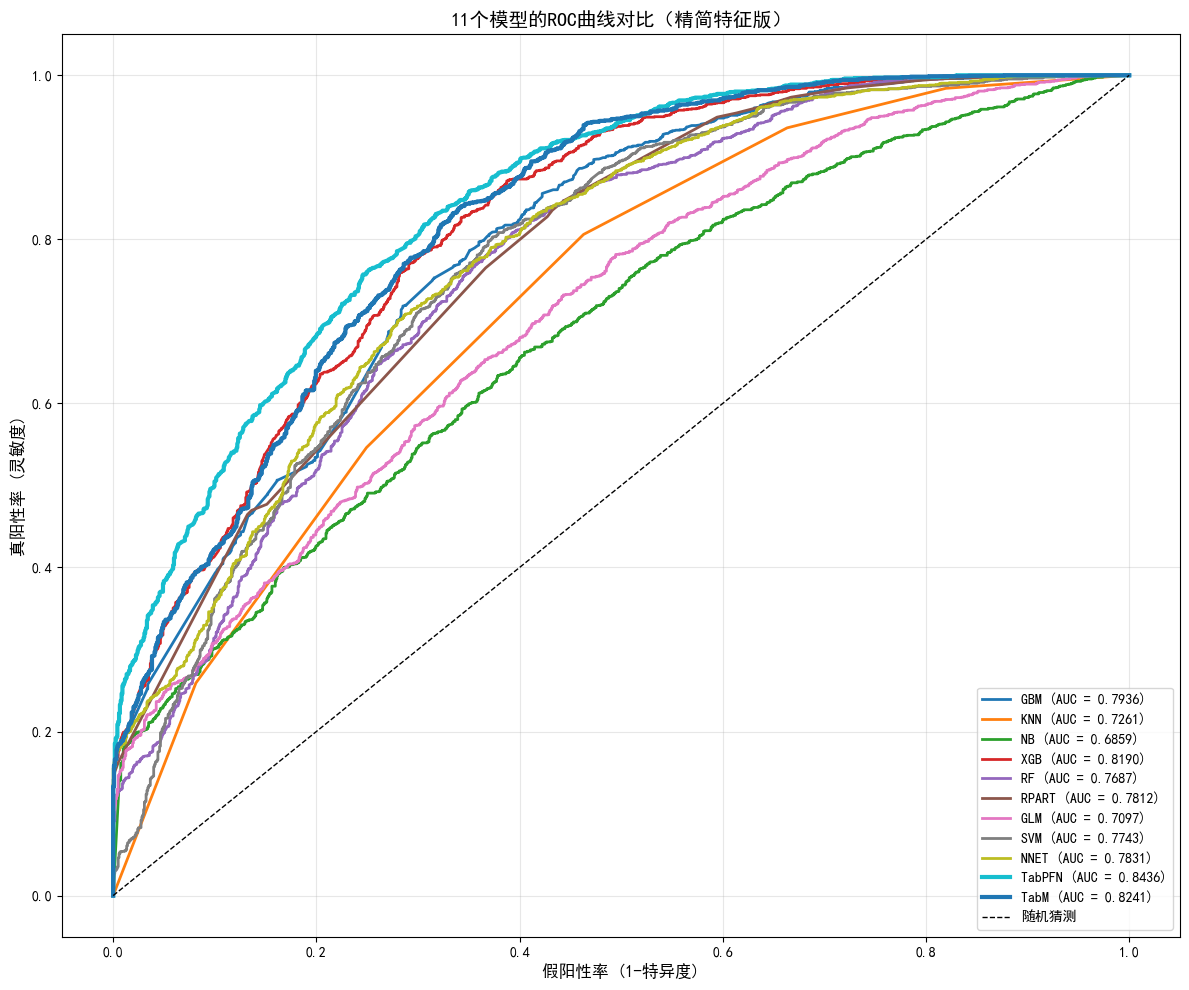

ROC曲线已保存


In [ ]:
plt.figure(figsize=(12, 10))

models_info = [
    ("GBM", y_pred_proba_gbm, auc_gbm),
    ("KNN", y_pred_proba_knn, auc_knn),
    ("NB", y_pred_proba_nb, auc_nb),
    ("XGB", y_pred_proba_xgb, auc_xgb),
    ("RF", y_pred_proba_rf, auc_rf),
    ("RPART", y_pred_proba_rpart, auc_rpart),
    ("GLM", y_pred_proba_glm, auc_glm),
    ("SVM", y_pred_proba_svm, auc_svm),
    ("NNET", y_pred_proba_nnet, auc_nnet),
    ("TabPFN", y_pred_proba_tabpfn, auc_tabpfn),
    ("TabM", y_pred_proba_tabm, auc_tabm),
]

for model_name, y_proba, auc_score in models_info:
    if auc_score > 0:
        fpr, tpr, _ = roc_curve(y_validation_binary, y_proba)
        linewidth = 3 if model_name in ["TabPFN", "TabM"] else 2
        plt.plot(
            fpr, tpr, label=f"{model_name} (AUC = {auc_score:.4f})", linewidth=linewidth
        )

plt.plot([0, 1], [0, 1], "k--", linewidth=1, label="随机猜测")
plt.xlabel("假阳性率 (1-特异度)", fontsize=12)
plt.ylabel("真阳性率 (灵敏度)", fontsize=12)
plt.title("11个模型的ROC曲线对比（精简特征版）", fontsize=14, fontweight="bold")
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig(
    "./output/ml_simplified/ROC曲线对比_11模型.pdf", dpi=300, bbox_inches="tight"
)
plt.savefig(
    "./output/ml_simplified/ROC曲线对比_11模型.png", dpi=300, bbox_inches="tight"
)
plt.show()

print("ROC曲线已保存")

## 24. 保存预测结果

In [26]:
predictions_df = pd.DataFrame(
    {
        "真实标签": y_validation_binary,
        "GBM_预测": y_pred_gbm,
        "GBM_概率": y_pred_proba_gbm,
        "KNN_预测": y_pred_knn,
        "KNN_概率": y_pred_proba_knn,
        "NB_预测": y_pred_nb,
        "NB_概率": y_pred_proba_nb,
        "XGB_预测": y_pred_xgb,
        "XGB_概率": y_pred_proba_xgb,
        "RF_预测": y_pred_rf,
        "RF_概率": y_pred_proba_rf,
        "RPART_预测": y_pred_rpart,
        "RPART_概率": y_pred_proba_rpart,
        "GLM_预测": y_pred_glm,
        "GLM_概率": y_pred_proba_glm,
        "SVM_预测": y_pred_svm,
        "SVM_概率": y_pred_proba_svm,
        "NNET_预测": y_pred_nnet,
        "NNET_概率": y_pred_proba_nnet,
        "TabPFN_预测": y_pred_tabpfn,
        "TabPFN_概率": y_pred_proba_tabpfn,
        "TabM_预测": y_pred_tabm,
        "TabM_概率": y_pred_proba_tabm,
    }
)

predictions_df.to_csv(
    "./output/ml_simplified/验证集预测结果_11模型.csv",
    index=False,
    encoding="utf-8-sig",
)
print(f"预测结果已保存，验证集共 {len(predictions_df)} 样本，包含11个模型的预测")
print(f"\n输出目录: ./output/ml_simplified/")

预测结果已保存，验证集共 2966 样本，包含11个模型的预测

输出目录: ./output/ml_simplified/
